# **The objective is to try and generate python code from an english sentence.**




In [1]:
#! pip install torchtext==0.6.0

In [2]:
CUDA_LAUNCH_BLOCKING="1"

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer1.png)

In [3]:
from google.colab import files
uploaded = files.upload()

Saving clean_data.txt to clean_data.txt


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
#from torchtext.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator,TabularDataset

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy

from spacy.tokenizer import Tokenizer
import numpy as np
import pandas as pd

import random
import math
import time
import os
import re
import keyword


In [5]:
SEED = 3333

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
!python -m spacy download en


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


# Data processing


Program to read the input data and process it for the transformer model
- Read the file and split into english and corresponding python code
- format the python code into one line
    - factor new line
    - factor tabs

Challenges in the input data

    - Messy start various options to segment the input data 
        #write ; #1 ; #  write
    - clean input file
        - removed # comments len < 10 & 20 after checking 
        - updated few manually
        - remove comments in the code ???
        # dd - remove pattern

Segment the input file
    - identify marker - messy data
    - extract segment
    - extract english sentence within segment
    - extract python code within python
    - format python code to one line






In [7]:
#out dataframe
out_df = pd.DataFrame(columns = ['src', 'python'])

input_file = 'clean_data.txt'
output_file = os.path.join('analysis_shortv3.txt')
# first print all lines starting with # with count
with open(output_file,'w') as out_file:
    eng_buf = ''
    py_buf = ''
    samples = 0
    with open(input_file) as in_file:
        for idx,line in enumerate(in_file):
            if line.startswith('#') and len(line) > 30:
                samples = samples + 1
                out_df.loc[len(out_df)] = [eng_buf,py_buf]
                py_buf = ''
                eng_buf = line
                #print(line)
                #out_file.write(line)
            else :
                py_buf = py_buf + line
                #out_file.write(line)
            #if samples > 10:
                #break
print(f" Count of # :{idx}")

# Data cleaning

# Replace tabs with 4 spaces and trim leading and trailing spaces

out_df['python']= out_df['python'].str.replace('\t', '    ')
out_df['python']= out_df['python'].str.strip()

# clean spaces 
# 3->4
# 7->8
# 11->12

reg3s_pat = re.compile(r'(:?\n)[\s]{3}([\w])')
reg7s_pat = re.compile(r'(:?\n)[\s]{7}([\w])')
reg11s_pat = re.compile(r'(:?\n)[\s]{11}([\w])')

def regex_clean(val):

    clean_py = reg3s_pat.sub(r'\1    \2', val)
    clean_py = reg7s_pat.sub(r'\1        \2', clean_py)
    clean_py = reg11s_pat.sub(r'\1            \2', clean_py)
    
    return clean_py

out_df['trg'] = out_df['python'].apply(regex_clean)


 Count of # :42424


# Data Augmentation Strategy

The # of original samples is ~4.5 K which cause the model to overfit.There are 2 potential approaches I considered : augment english text or augment python code. As changing of english text might change the semantics/ context; considered only augmenting python code. Approach for augmenting python code

Replace functions names and give generic names
Replace var names and give generic names

In [8]:
# Patterns to match function and variable names
func_pat = re.compile('def (?P<func_name>[\w]+?)\(')
var_pat = re.compile(r'\n\s*(?P<var_name>[\w]+?)\s*=')

# Create new dataset by regex matching function 
# and variable names and giving generic names
final_df = pd.DataFrame(columns = ['src','trg'])
for row_idx,row in out_df.iterrows():
    # base copy
    final_df.loc[len(final_df)] = [row.src,row.trg]
    var_list = []
    func_list = []
    #print(row.trg)
    func_list = list(set(func_pat.findall(row.trg)))
    var_list = list(set(var_pat.findall(row.trg)))
    if var_list:
        for var_idx,var in enumerate(var_list):
            varname = "var_"+ str(var_idx)
            final_df.loc[len(final_df)] = [row.src,row.trg.replace(var,varname)]
    if func_list:
        for func_idx,func in enumerate(func_list):
            funcname = "func_"+ str(func_idx)
            final_df.loc[len(final_df)] = [row.src,row.trg.replace(func,funcname)]
    #if row_idx == 3: break
    

In [9]:
'''
out_df['len'] = out_df['trg'].str.len()
fout_df = out_df[out_df['len'] < 500][['src','trg']]
print(len(fout_df)/len(out_df))
fout_df.to_csv('p_data.csv')
'''
final_df['len'] = final_df['trg'].str.len()
fout_df = final_df[final_df['len'] < 500][['src','trg']]
print(len(fout_df)/len(final_df))
fout_df.to_csv('p_data.csv')

0.8974421240084183


In [89]:
print(f"Data Samples after augmentation : {len(final_df)}")

Data Samples after augmentation : 12354


In [11]:
spacy_en = spacy.load('en')

In [12]:

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

# Tokenization Approach

* Built a custom tokenizer using the spacy(en) as base
* custom rules
* factor spaces as a token
* key words
* tabs after : and in blocks
* == , >=, <= to be treated as single token
* handled [,],(,),{,}

In [13]:
# Tokenizer for python

# Get all keywords
kw_dict = {}
for kw in keyword.kwlist:
    kw_dict[kw]= [{"ORTH":kw}]

# learn 4, 8 12 spaces
special_tabs = ['\\n    ','\\n        ','\\n            ']
for tab in special_tabs:
    kw_dict[tab] = [{"ORTH":tab}]
#kw_dict    

special_cases = kw_dict
#prefix_re = re.compile(r'''^[\[\("']''')
#suffix_re = re.compile(r'''[\]\)"']$''')
#infix_re = re.compile(r'''(==|>=|<=|!=|\(|\)|:|"|\[|\]|=|,|')''')
# Mar17 infix_re = re.compile(r'''(==|>=|<=|!=|\(|\)|:|\[|\]|=|,)''')
infix_re = re.compile(r'''(==|>=|<=|!=|\,|\?|\:|\;|.
                          |\‘|\’|\`|\“|\”|\"|\'|~|\(|\)|\[|\])''')
#infix_re = re.compile(r'''(==|>=|<=|!=|:|=|,)''')


def python_tokenizer(nlp):
    return Tokenizer(nlp.vocab, #rules=special_cases,
                                #prefix_search=prefix_re.search,
                                #suffix_search=suffix_re.search,
                                infix_finditer=infix_re.finditer)
                                #url_match=simple_url_re.match)


py_custom = python_tokenizer(spacy_en)

# Modifiy the tokenizer to factor whitespace

In [14]:
#Modified the py thokenizer to factor spaces

def tokenize_py(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    token_texts = []
    for token in py_custom(text):
       token_texts.append(token.text)
       if token.whitespace_:  # filter out empty strings
           token_texts.append(token.whitespace_)
    return token_texts

In [15]:
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_py, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

fields = {'src' : ('src', SRC),
          'trg' : ('trg', TRG)}

In [16]:
e2p_data  = TabularDataset(
                            path = 'p_data.csv',
                            format = 'csv',
                            fields = fields
                            )

In [17]:
train_data, valid_data, test_data = e2p_data.split([0.7,.2,.1])

In [18]:
SRC.build_vocab(train_data, min_freq = 1)
TRG.build_vocab(train_data, min_freq = 1)

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [20]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device,
    sort_within_batch = True,
    sort_key = lambda x: len(x.src))

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-encoder.png)

In [21]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 300):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [22]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-attention.png)

In [23]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [24]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-decoder.png)

In [25]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 300):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [26]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # query, key, value
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

10000
11000
11100
11100
11100

In [27]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

In [28]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [29]:
len(TRG.vocab)

8756

In [30]:
device

device(type='cuda')

In [31]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [32]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,142,836 trainable parameters


In [33]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [34]:
model.apply(initialize_weights);

In [35]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [36]:
#modified the loss function
# Built a custom function
# If keyword or tab :5
# If among top 50 most frequent : 4 ( most common happen to be ones that help wtih syntax)
# Rest had a weight 1

py_toks = ['(',')','{','}','[',']',':',',',';',
            '+','-','*','/','|','&','<','>','=','.',
            '%','==','!=','<=','>=','~','^','**',
            '+=','-=','*=','/=','%=','/=','//']

weight_list = []
for idx,word in enumerate(TRG.vocab.itos):


  #default
  weight = 1.0 
 

  # keyword or tab or common tokens
  if (keyword.iskeyword(word)) or ('\n' in word) or (word in py_toks):
      weight = 2.0
  
  weight_list.append(weight)

class_weights = torch.FloatTensor(weight_list).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index = TRG_PAD_IDX)


In [37]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [38]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [39]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [40]:
training_vis = pd.DataFrame(columns=['epoch','train_loss','val_loss'])
N_EPOCHS = 30
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    training_vis.loc[len(training_vis)] = [epoch+1,train_loss,valid_loss]

Epoch: 01 | Time: 0m 24s
	Train Loss: 5.029 | Train PPL: 152.767
	 Val. Loss: 3.134 |  Val. PPL:  22.968
Epoch: 02 | Time: 0m 23s
	Train Loss: 2.802 | Train PPL:  16.472
	 Val. Loss: 2.464 |  Val. PPL:  11.754
Epoch: 03 | Time: 0m 24s
	Train Loss: 2.355 | Train PPL:  10.536
	 Val. Loss: 2.138 |  Val. PPL:   8.483
Epoch: 04 | Time: 0m 24s
	Train Loss: 2.077 | Train PPL:   7.984
	 Val. Loss: 1.899 |  Val. PPL:   6.681
Epoch: 05 | Time: 0m 24s
	Train Loss: 1.847 | Train PPL:   6.338
	 Val. Loss: 1.668 |  Val. PPL:   5.301
Epoch: 06 | Time: 0m 25s
	Train Loss: 1.657 | Train PPL:   5.243
	 Val. Loss: 1.513 |  Val. PPL:   4.541
Epoch: 07 | Time: 0m 24s
	Train Loss: 1.494 | Train PPL:   4.456
	 Val. Loss: 1.375 |  Val. PPL:   3.955
Epoch: 08 | Time: 0m 25s
	Train Loss: 1.360 | Train PPL:   3.897
	 Val. Loss: 1.261 |  Val. PPL:   3.528
Epoch: 09 | Time: 0m 25s
	Train Loss: 1.240 | Train PPL:   3.456
	 Val. Loss: 1.145 |  Val. PPL:   3.143
Epoch: 10 | Time: 0m 25s
	Train Loss: 1.128 | Train PPL

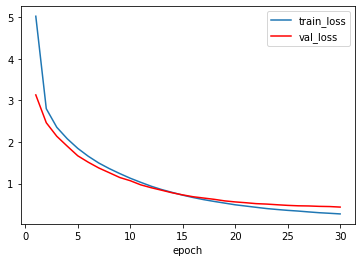

In [41]:
ax = plt.gca()

training_vis.plot(kind='line',x='epoch',y='train_loss',ax=ax)
training_vis.plot(kind='line',x='epoch',y='val_loss', color='red', ax=ax)

plt.show()


In [42]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 0.446 | Test PPL:   1.562 |


In [43]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 500):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [44]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [45]:
# Function to display generated python code

def display_py(trans_list):
  print('\n')
  final_str = ''
  for string in trans_list:
    if string != '\n':
      final_str = final_str + string
    else:
      final_str= final_str + string
  return final_str

In [46]:
example_idx = random.randint(0,len(train_data))

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')
print(display_py(trg))

src = ['#', 'write', 'a', 'python', 'function', 'to', 'calculate', 'the', 'dot', 'product', 'of', 'two', 'lists']
trg = ['def', ' ', 'func_0', '(', 'l1', ',', ' ', 'l2', ')', ':', '\n    ', 'return', ' ', 'sum', '(', 'x*y', ' ', 'for', ' ', 'x', ',', 'y', ' ', 'in', ' ', 'zip', '(', 'l1', ',', ' ', 'l2', ')', ')']


def func_0(l1, l2):
    return sum(x*y for x,y in zip(l1, l2))


In [47]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')
print(display_py(translation[:-1]))

predicted trg = ['def', ' ', 'dot_product', '(', 'a', ',', ' ', 'b', ')', ':', '\n    ', 'return', ' ', 'sum', '(', ' ', 'e', '[', '0', ']', ' ', '*', ' ', 'e', '[', '1', ']', ' ', 'for', ' ', 'e', ' ', 'in', ' ', 'zip', '(', 'a', ',', ' ', 'b', ')', ')', '<eos>']


def dot_product(a, b):
    return sum( e[0] * e[1] for e in zip(a, b))


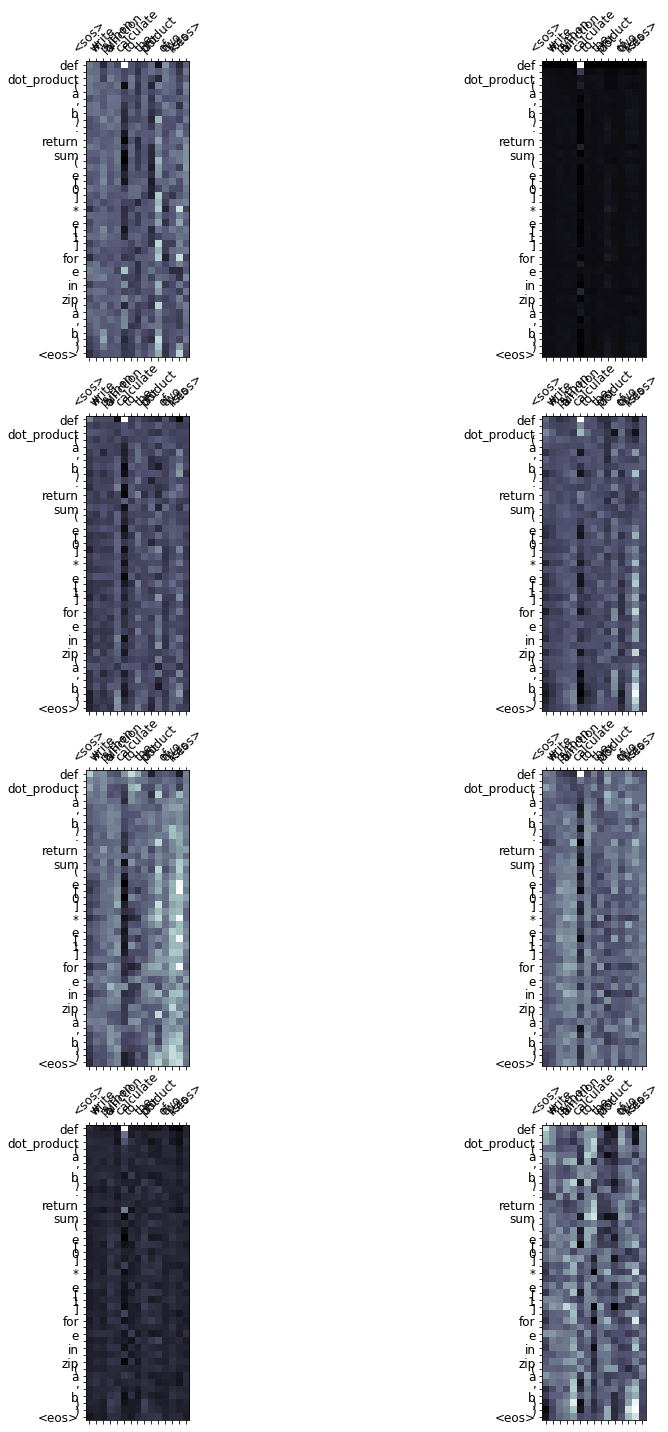

In [48]:
display_attention(src, translation, attention)


In [49]:
example_idx = random.randint(0,len(valid_data))

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')
print(display_py(trg))

src = ['#', '41', '.', 'python', 'program', 'to', 'add', 'two', 'matrices', 'using', 'nested', 'list', 'comprehension']
trg = ['x', ' ', '=', ' ', '[', '[', '12', ',', '7', ',', '3', ']', ',', '\n    ', '[4', ' ', ',5', ',', '6', ']', ',', '\n    ', '[7', ' ', ',8', ',', '9', ']', ']', '\n\n', 'y', ' ', '=', ' ', '[', '[', '5', ',', '8', ',', '1', ']', ',', '\n    ', '[6', ',', '7', ',', '3', ']', ',', '\n    ', '[4', ',', '5', ',', '9', ']', ']', '\n\n', 'var_0', ' ', '=', ' ', '[', '[', 'x', '[', 'i', ']', '[', 'j', ']', ' ', '+', ' ', 'y', '[', 'i', ']', '[', 'j', ']', ' ', ' ', 'for', ' ', 'j', ' ', 'in', ' ', 'range', '(', 'len', '(', 'x', '[', '0', ']', ')', ')', ']', ' ', 'for', ' ', 'i', ' ', 'in', ' ', 'range', '(', 'len', '(', 'x', ')', ')', ']', '\n\n', 'for', ' ', 'r', ' ', 'in', ' ', 'var_0', ':', '\n    ', 'print', '(', 'r', ')']


x = [[12,7,3],
    [4 ,5,6],
    [7 ,8,9]]

y = [[5,8,1],
    [6,7,3],
    [4,5,9]]

var_0 = [[x[i][j] + y[i][j]  for j in range(len(x[0]))] f

In [50]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')
print(display_py(translation[:-1]))

predicted trg = ['x', ' ', '=', ' ', '[', '[', '12', ',', '7', ',', '3', ']', ',', '\n    ', '[4', ' ', ',5', ',', '6', ']', ',', '\n    ', '[7', ' ', ',8', ',', '9', ']', ']', '\n\n', 'y', ' ', '=', ' ', '[', '[', '5', ',', '8', ',', '1', ']', ',', '\n    ', '[6', ',', '7', ',', '3', ']', ',', '\n    ', '[4', ',', '5', ',', '9', ']', ']', '\n\n', 'result', ' ', '=', ' ', '[', '[', 'x', '[', 'i', ']', '[', 'j', ']', ' ', '+', ' ', 'y', '[', 'i', ']', ' ', ' ', 'for', ' ', 'r', ' ', 'in', ' ', 'result', ':', '\n    ', 'print', '(', 'r', ')', '<eos>']


x = [[12,7,3],
    [4 ,5,6],
    [7 ,8,9]]

y = [[5,8,1],
    [6,7,3],
    [4,5,9]]

result = [[x[i][j] + y[i]  for r in result:
    print(r)


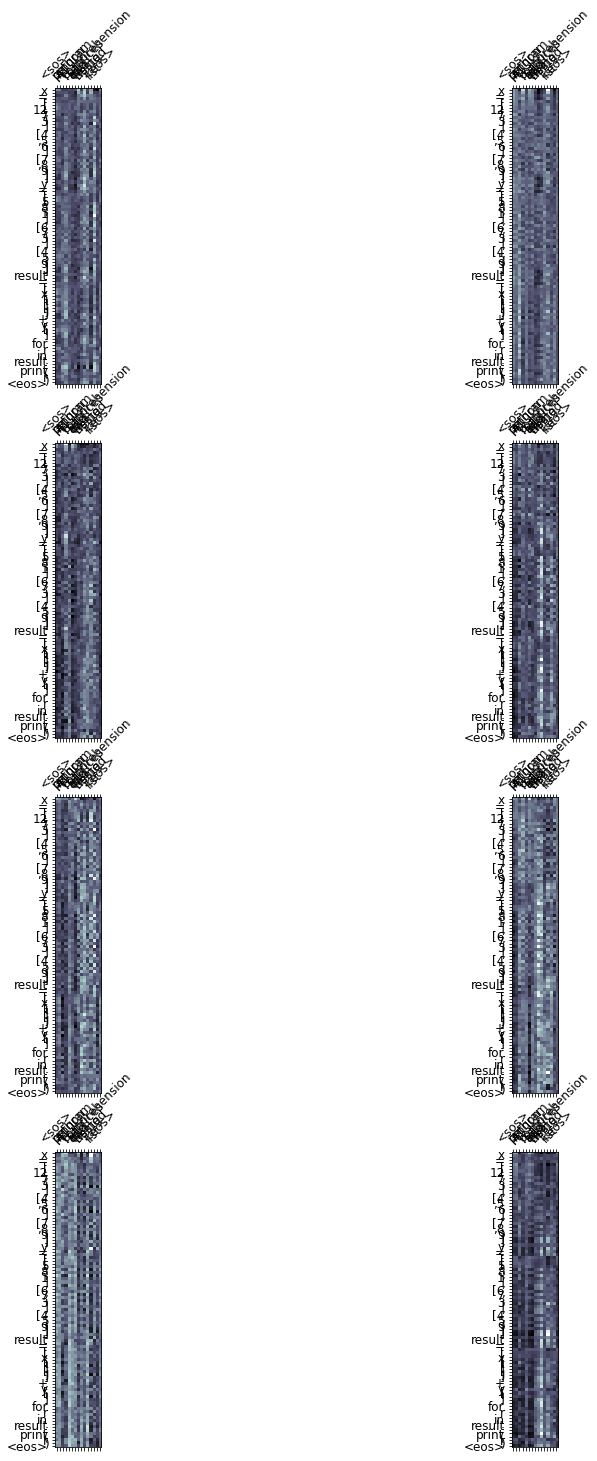

In [51]:
display_attention(src, translation, attention)


In [52]:
example_idx = random.randint(0,len(test_data))

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')
print(display_py(trg))

src = ['#', 'write', 'a', 'python', 'function', 'to', 'generate', '6', 'digit', 'otp']
trg = ['import', ' ', 'math', ',', ' ', 'random', '\n', 'def', ' ', 'generateotp', '(', ')', ' ', ':', '\n    ', 'digits', ' ', '=', ' ', '"0123456789', '"', '\n    ', 'otp', ' ', '=', ' ', '"', '"', '\n    ', 'for', ' ', 'i', ' ', 'in', ' ', 'range', '(', '6', ')', ' ', ':', '\n        ', 'otp', ' ', '+=', ' ', 'digits', '[', 'math.floor', '(', 'random.random', '(', ')', ' ', '*', ' ', '10', ')', ']', '\n    ', 'return', ' ', 'otp']


import math, random
def generateotp() :
    digits = "0123456789"
    otp = ""
    for i in range(6) :
        otp += digits[math.floor(random.random() * 10)]
    return otp


In [53]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')
print(display_py(translation[:-1]))

predicted trg = ['import', ' ', 'math', ',', ' ', 'random', '\n', 'def', ' ', 'generatevar_0', '(', ')', ' ', ':', '\n    ', 'digits', ' ', '=', ' ', '"0123456789', '"', '\n    ', 'var_0', ' ', '=', ' ', '"', '\n    ', 'for', ' ', 'i', ' ', 'in', ' ', 'range', '(', '5', ')', ' ', ':', '\n        ', 'var_0', ' ', '+=', ' ', 'var_0', '[', 'i', ']', '\n    ', 'return', ' ', 'var_0', '<eos>']


import math, random
def generatevar_0() :
    digits = "0123456789"
    var_0 = "
    for i in range(5) :
        var_0 += var_0[i]
    return var_0


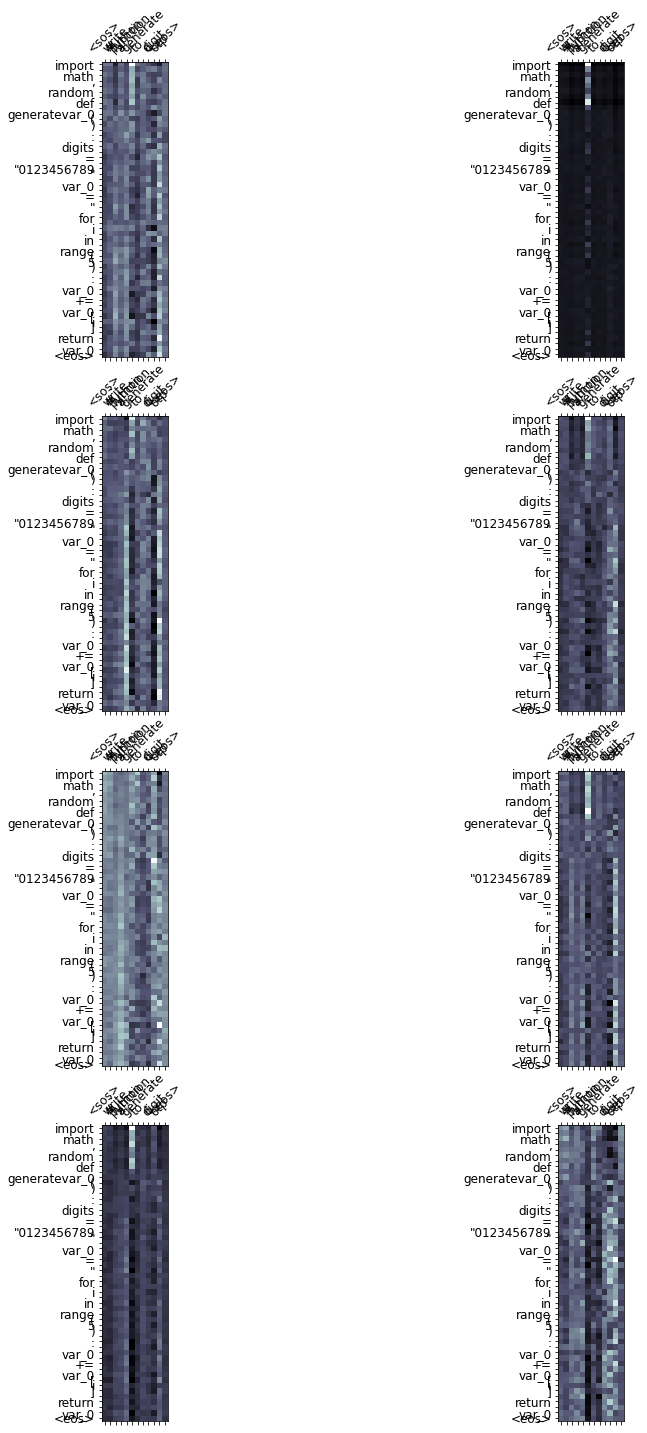

In [54]:
display_attention(src, translation, attention)


In [55]:
def translate_sentence_vectorized(src_tensor, src_field, trg_field, model, device, max_len=500):
    assert isinstance(src_tensor, torch.Tensor)

    model.eval()
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
    # enc_src = [batch_sz, src_len, hid_dim]

    trg_indexes = [[trg_field.vocab.stoi[trg_field.init_token]] for _ in range(len(src_tensor))]
    # Even though some examples might have been completed by producing a <eos> token
    # we still need to feed them through the model because other are not yet finished
    # and all examples act as a batch. Once every single sentence prediction encounters
    # <eos> token, then we can stop predicting.
    translations_done = [0] * len(src_tensor)
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        pred_tokens = output.argmax(2)[:,-1]
        for i, pred_token_i in enumerate(pred_tokens):
            trg_indexes[i].append(pred_token_i)
            if pred_token_i == trg_field.vocab.stoi[trg_field.eos_token]:
                translations_done[i] = 1
        if all(translations_done):
            break

    # Iterate through each predicted example one by one;
    # Cut-off the portion including the after the <eos> token
    pred_sentences = []
    for trg_sentence in trg_indexes:
        pred_sentence = []
        for i in range(1, len(trg_sentence)):
            if trg_sentence[i] == trg_field.vocab.stoi[trg_field.eos_token]:
                break
            pred_sentence.append(trg_field.vocab.itos[trg_sentence[i]])
        pred_sentences.append(pred_sentence)

    return pred_sentences, attention

In [56]:
from torchtext.data.metrics import bleu_score

def calculate_bleu_alt(iterator, src_field, trg_field, model, device, max_len = 50):
    trgs = []
    pred_trgs = []
    with torch.no_grad():
        for batch in iterator:
            src = batch.src
            trg = batch.trg
            _trgs = []
            for sentence in trg:
                tmp = []
                # Start from the first token which skips the <start> token
                for i in sentence[1:]:
                    # Targets are padded. So stop appending as soon as a padding or eos token is encountered
                    if i == trg_field.vocab.stoi[trg_field.eos_token] or i == trg_field.vocab.stoi[trg_field.pad_token]:
                        break
                    tmp.append(trg_field.vocab.itos[i])
                _trgs.append([tmp])
            trgs += _trgs
            pred_trg, _ = translate_sentence_vectorized(src, src_field, trg_field, model, device)
            pred_trgs += pred_trg
    return pred_trgs, trgs, bleu_score(pred_trgs, trgs)

In [57]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 500):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [58]:
#bleu_score = calculate_bleu_alt(test_data, SRC, TRG, model, device)

#print(f'BLEU score = {bleu_score*100:.2f}')

In [59]:
test_sample_idxs = [random.randint(0, len(train_data)) for p in range(0, 25)]
for count,example_idx in enumerate(test_sample_idxs):
  src = vars(train_data.examples[example_idx])['src']
  trg = vars(train_data.examples[example_idx])['trg']
  print(50*"*" + 'Sample    : ' + str(count + 1) + '  ' + 50*"*")
  print('\n')
  print("*******Gold *******")
  eng = ' '.join(src)
  label = display_py(trg)
  print(eng)
  print(label)
  print('\n')
  #print(' '.join(trg))

  print("*******Predicted *******")
  translation, attention = translate_sentence(src, SRC, TRG, model, device)

  print(f'predicted trg = {translation}')
  print(display_py(translation[:-1]))
  print('\n')
  print(100* "*")
  print('\n')

**************************************************Sample    : 1  **************************************************


*******Gold *******


# write a python function using list comprehension to find even numbers in a list
def find_evennumbers(input_list):
  var_0 = [var for var in input_list if var % 2 == 0]
  return var_0


*******Predicted *******
predicted trg = ['def', ' ', 'find_evennumbers', '(', 'input_list', ')', ':', '\n  ', 'list_using_comp', ' ', '=', ' ', '[var', ' ', 'for', ' ', 'var', ' ', 'in', ' ', 'input_list', ' ', 'if', ' ', 'var', ' ', '%', ' ', '2', ' ', '==', ' ', '0', ']', '\n  ', 'return', ' ', 'list_using_comp', '<eos>']


def find_evennumbers(input_list):
  list_using_comp = [var for var in input_list if var % 2 == 0]
  return list_using_comp


****************************************************************************************************


**************************************************Sample    : 2  **************************************************


In [99]:
src ="write a function to subtract 2 numbers"

translation, attention = translate_sentence(src, SRC, TRG, model, device)
#print(len(translation))
print(f'predicted trg = {translation}')
print(''.join(translation[:-1]))

predicted trg = ['def', ' ', 'var_0_two_numbers', '(', 'num1', ',', ' ', 'num2', ')', ':', '\n    ', 'var_0', ' ', '=', ' ', 'num1', ' ', '-', ' ', 'num2', '\n    ', 'return', ' ', 'var_0', '<eos>']
def var_0_two_numbers(num1, num2):
    var_0 = num1 - num2
    return var_0
